#final project#

# Load libraries and change dataframe display

In [1]:
# loading the required libraries

import numpy as np
import pandas as pd 
import scipy.sparse
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import jellyfish
from tqdm import tqdm_notebook
from itertools import product
from sklearn.feature_extraction.text import TfidfVectorizer

import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error



# Downcast dtypes from 64 to 32 bit to save memory
# by creating a downcast function

def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df



# setting the dataframes display

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

In [2]:
# installing py-translate for text translation(here, from russian to english)
!pip install py-translate

# Load data subset

In [3]:
sales = pd.read_csv("sales_train.csv",parse_dates=['date'])
item_cats = pd.read_csv('item_categories.csv')
items = pd.read_csv('items.csv')
#sample_submission = pd.read_csv('sample_submission.csv')
shops = pd.read_csv('shops.csv')
test = pd.read_csv('test.csv')

## EDA

In [4]:
# checking sales shape
print(f'sales dataframe shape: {sales.shape}')

# looking for missing values
print(sales.isna().sum())

sales.head()

sales dataframe shape: (2935849, 6)
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1.0
1,2013-03-01,0,25,2552,899.00,1.0
2,2013-05-01,0,25,2552,899.00,-1.0
3,2013-06-01,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [5]:
sales.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


remarks from those statistics :
- there is an outlier for item_price
- there is a negative item_price
- there is an outlier for item_cnt_day

item_price outlier:
- the item_price max seems to be way far from the mean let's check the corresponding item and its prices over that period to see if it's not a typing error

In [6]:
sales[sales['item_price']==sales['item_price'].max()]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,2013-12-13,11,12,6066,307980.0,1.0


In [7]:
# let's check if there is another record for this item
sales[sales['item_id']==6066]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,2013-12-13,11,12,6066,307980.0,1.0


this is the only record for this item

In [8]:
# checking for the corresponding item_name 
items[items['item_id']==6066]

,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75


according to google translate лиц means persons, so maybe it's the total amount paid by 522 customers for this item but in the other hand the item_cnt_day is 1, so it's better to drop this item especially since this item is not in test dataframe

In [9]:
# checking that item_id equal to 6066 is not in the test data
test[test['item_id']==6066]

,ID,shop_id,item_id


In [10]:
# dropping the row with item_id equal to 6066
sales.drop(sales[sales['item_id']==6066].index,inplace=True)

negative item_price:
- we have also an item_price equal to -1, let's check for all item_price<0

In [11]:
sales[sales['item_price']<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1.0


In [12]:
# let's see if we don't have another record with the corresponding item to check for the right price (for the same period and same shop)
sales[(sales['item_id']==2973) & (sales['shop_id']==32) & (sales['date_block_num']==4)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484682,2013-05-23,4,32,2973,1249.0,1.0
484683,2013-05-15,4,32,2973,-1.0,1.0
484684,2013-06-05,4,32,2973,2499.0,1.0


hard to say if it's 1249 or 2499 which is by the way the double, we are going to fill this value with the item_price mean

In [13]:
sales.iloc[484683,4] = sales[(sales['item_id']==2973) & (sales['shop_id']==32) & (sales['date_block_num']==4)]['item_price'].mean()

item_cnt_day outlier:
- let's check for item_cnt_day maximum and see what is the corresponding item

In [14]:
sales[sales['item_cnt_day']==sales['item_cnt_day'].max()]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2909818,2015-10-28,33,12,11373,0.908714,2169.0


In [15]:
# now we can check the item_cnt_day for all the records with the same item_id
sales[sales['item_id']==11373]['item_cnt_day'].describe()

count     464.000000
mean       14.144397
std       104.604937
min         1.000000
25%         2.000000
50%         4.000000
75%         8.000000
max      2169.000000
Name: item_cnt_day, dtype: float64

mean is 14 and median is 4 so 2169 doesn't seem to be a correct recording so we are going to drop this row

In [16]:
# dropping the rows with item_cnt_day equal to 2169 
sales.drop(sales[sales['item_cnt_day']==sales['item_cnt_day'].max()].index,inplace=True)

In [17]:
# now that we took care of all the ouliers and incorrect values, let's check for duplicate rows in our sales dataframe
sales[sales.duplicated()==True]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76962,2013-05-01,0,54,20130,149.0,1.0
1435367,2014-02-23,13,50,3423,999.0,1.0
1496766,2014-03-23,14,21,3423,999.0,1.0
1671873,2014-01-05,16,50,3423,999.0,1.0
1866340,2014-12-07,18,25,3423,999.0,1.0
2198566,2014-12-31,23,42,21619,499.0,1.0


it seems we have duplicated recordings because for the same shop, same item and same day. If we had more than one sale we would have item_cnt_day > 1 instead of many recordings. so we need to drop these rows

In [18]:
# dropping the duplicated rows
sales.drop_duplicates(inplace=True)

## Feature extraction from text

### shops table

In [19]:
# checking shops shape
print(f'shops dataframe shape: {shops.shape}')

# looking for missing values
print(shops.isna().sum())

shops.head()

shops dataframe shape: (60, 2)
shop_name    0
shop_id      0
dtype: int64


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [20]:
# checking that we don't have duplicated shop_name
# first we need to remove uppercases
shops['shop_name'] = shops['shop_name'].apply(lambda x:x.lower())
shops[shops.duplicated(subset='shop_name')==True]

,shop_name,shop_id


no duplicates

In [21]:
# now let's translate some random shop names to understand to structure because a lot of names seem to start with the same word
from translate import translator
translator('ru','en','Волжский ТЦ "Волга Молл"')[0][0][0] 

HTTPError: ignored

we can notice that the shop name begins with the city location Volzhsky and then the shop category (here it's a shopping center)
let's check other shop_name

In [385]:
translator('ru','en','!Якутск Орджоникидзе, 56 фран')[0][0][0] 

HTTPError: ignored

here the city is Yakutsk but there isn't a shop category

In [25]:
translator('ru','en','калуга трц "xxi век"')[0][0][0]	

'Kaluga TPC "XXI Century"'

same here, city then no shop category then shop name

In [21]:
#let's extract the city from shop_name
shops['shop_city'] = shops['shop_name'].apply(lambda x: x.split(' ')[0])

In [260]:
# checking unique values for shop_city and then translating all the city names in english just to be sure it's a city
print('number of unique cities extracted from shops table: ',shops['shop_city'].nunique())
unique_shops = shops['shop_city'].unique()
city_translation = {}
for city in unique_shops:
  city_translation[city]=translator('ru','en',city)[0][0][0]	


number of unique cities extracted from shops table:  32


HTTPError: ignored

In [45]:
city_translation

{'no_city': 'no_city',
 'адыгея': 'Adygea',
 'балашиха': 'Balashikha',
 'волжский': 'Volzhsky',
 'вологда': 'Vologda',
 'воронеж': 'Voronezh',
 'жуковский': 'Zhukovsky',
 'казань': 'Kazan.',
 'калуга': 'Kaluga',
 'коломна': 'Kolomna',
 'красноярск': 'Krasnoyarsk',
 'курск': 'Kursk',
 'москва': 'Moscow',
 'мытищи': 'Mytishchi.',
 'н.новгород': 'N.Novgorod',
 'новосибирск': 'Novosibirsk',
 'омск': 'Omsk',
 'ростовнадону': 'Rostovnadon',
 'самара': 'Samara',
 'сергиев': 'Sergiev',
 'спб': 'St. Petersburg',
 'сургут': 'Surgut',
 'томск': 'Tomsk',
 'тюмень': 'Tyumen.',
 'уфа': 'Ufa',
 'химки': 'Khimki',
 'чехов': 'Chekhov',
 'якутск': 'Yakutsk',
 'ярославль': 'Yaroslavl'}

remarks : 
- ! Yakutsk has to be replaced by Yakutsk
- Exit has to be dropped
- Online store has to be dropped but we can create a shop category including shopping mall that can be useful
- Digital has to be the same shop category as Online store


In [22]:
# correcting shop_city column
shops['shop_city'].replace({'!якутск':'якутск','интернет-магазин':'no_city','выездная':'no_city','цифровой':'no_city'},inplace=True)

In [23]:
# creating a shop_category column by extracting 'тц' : 'mall' , 'трц' : 'shopping center' ,'интернет-магазин': 'Online store' , 'цифровой': 'digital'
# 'склад' : 'warehouse'
# we are going to assume that mall is the same than shopping center and oneline store and digital are also the same
shop_cats = ['тц', 'трц', 'интернет-магазин', 'цифровой', 'склад']
category=[]
for shop in shops['shop_name']:
  if 'тц' in shop or 'трц' in shop:
    category.append('тц')
  elif 'интернет-магазин' in shop:
    category.append('интернет-магазин')
  elif 'цифровой' in shop:
    category.append('цифровой')
  elif 'склад' in shop:
    category.append('склад')
  else:
    category.append('no_category')

shops['shop_category']=category

In [24]:
# removing city from shop_name
shops['shop_name'] = shops['shop_name'].apply(lambda x: x[x.index(' ') + 1:])

In [25]:
# removing shop_category from shop_name
for i in shop_cats:
  for x in range(len(shops)):
    if i in shops['shop_name'][x]:
      shops['shop_name'][x] = shops['shop_name'][x].strip('тц')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [26]:
shops.shape

(60, 4)

### items table

In [27]:
# checking items shape
print(f'items dataframe shape: {items.shape}')

# looking for missing values
print(items.isna().sum())

items.head()

items dataframe shape: (22170, 3)
item_name           0
item_id             0
item_category_id    0
dtype: int64


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [28]:
# checking that we don't have duplicate item_name
items['item_name'] = items['item_name'].apply(lambda x:x.lower())
duplicated_items = items[items.duplicated(subset='item_name',keep=False)==True]
print('number of duplicated rows: ',len(duplicated_items))
duplicated_items.head()

number of duplicated rows:  118


,item_name,item_id,item_category_id
8247,алые паруса (регион),8247,40
8248,алые паруса (регион),8248,40
8289,английский вместе с хрюшей и… ч. 1 (регион),8289,40
8290,английский вместе с хрюшей и… ч. 1 (регион),8290,40
8298,андрей рублев (регион),8298,40


we have a lot of duplicates here !
we need to remove duplicated items

In [29]:
# we are going to keep the first item_id for each group of duplicated item_ids in order to change them in sales and test datasets
first_duplicated_items = duplicated_items.groupby('item_name',as_index=False).agg(first_item_id=pd.NamedAgg(column='item_id',aggfunc='first'))
# then we merge duplicated_items with first_duplicated_items in order the to match the duplicated item_ids with the first item_id
duplicated_items = pd.merge(duplicated_items,first_duplicated_items, how ='left' , on='item_name')
duplicated_items.head()

,item_name,item_id,item_category_id,first_item_id
0,алые паруса (регион),8247,40,8247
1,алые паруса (регион),8248,40,8247
2,английский вместе с хрюшей и… ч. 1 (регион),8289,40,8289
3,английский вместе с хрюшей и… ч. 1 (регион),8290,40,8289
4,андрей рублев (регион),8298,40,8298


In [30]:
# now we gonna create a dictionnary with keys equal to item_ids and values equal to first_item_ids
# in order to replace duplicated item_ids in sales and test data with one item_id
first_item_dict = pd.Series(duplicated_items['first_item_id'].values,duplicated_items['item_id'].values).to_dict()

In [31]:
# now we can replace duplicated item_ids in sales and test
sales['item_id'] = sales['item_id'].replace(first_item_dict)
test['item_id'] = test['item_id'].replace(first_item_dict)

In [32]:
# finally we can drop the duplicates in items dataframe
items.drop_duplicates('item_name',inplace=True) #keep='first' is set by default

In [33]:
del duplicated_items, first_duplicated_items, first_item_dict
gc.collect()

307

### item_cats table

In [34]:
# checking item_cats shape
print(f'item_cats dataframe shape: {item_cats.shape}')

# looking for missing values
print(item_cats.isna().sum())

item_cats.head()

item_cats dataframe shape: (84, 2)
item_category_name    0
item_category_id      0
dtype: int64


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [35]:
# checking that we don't have duplicate item_category_name
item_cats['item_category_name'] = item_cats['item_category_name'].apply(lambda x: x.lower())
item_cats[item_cats.duplicated(subset='item_category_name')==True]

,item_category_name,item_category_id


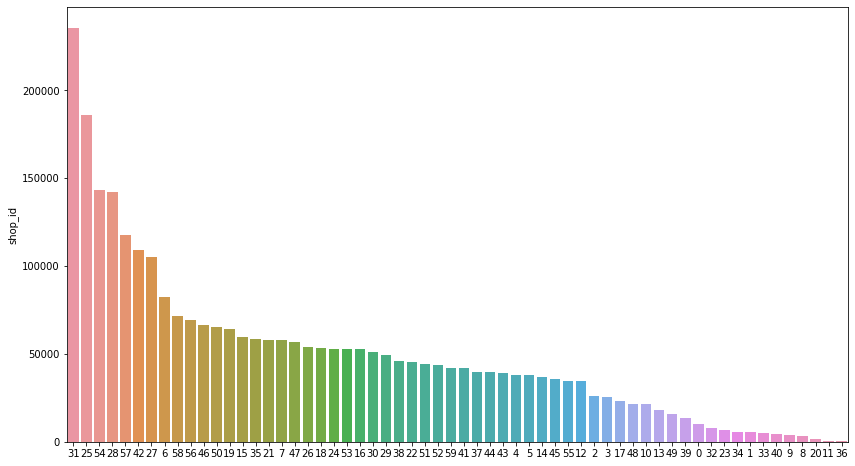

In [36]:
# number of transactions per shop in the sales dataframe
shop_id_count = sales['shop_id'].value_counts(ascending=False)
plt.figure(figsize=(14,8))
sns.barplot(x=shop_id_count.index , y=shop_id_count , order=shop_id_count.index)
plt.show()

in the sales dataframe, the number of appearance of each shop is not uniformly distributed, we have some shops that have more than 100000 appearances and other with less than 10000

In [486]:
del shop_id_count
gc.collect()

581

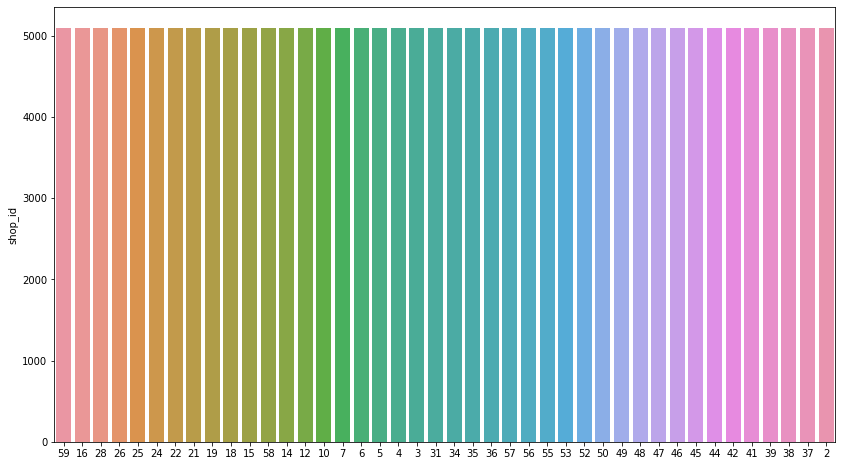

In [334]:
# number of transactions per shop in the test dataframe
shop_id_count_test = test['shop_id'].value_counts(ascending=False)
plt.figure(figsize=(14,8))
sns.barplot(x=shop_id_count_test.index , y=shop_id_count_test , order=shop_id_count_test.index)
plt.show()

in the test dataframe, the number of appearance per shop is perfectly uniform. in order the keep the information from sales dataframe we will have to mean encode shop_id 

In [484]:
del shop_id_count_test
gc.collect()

370

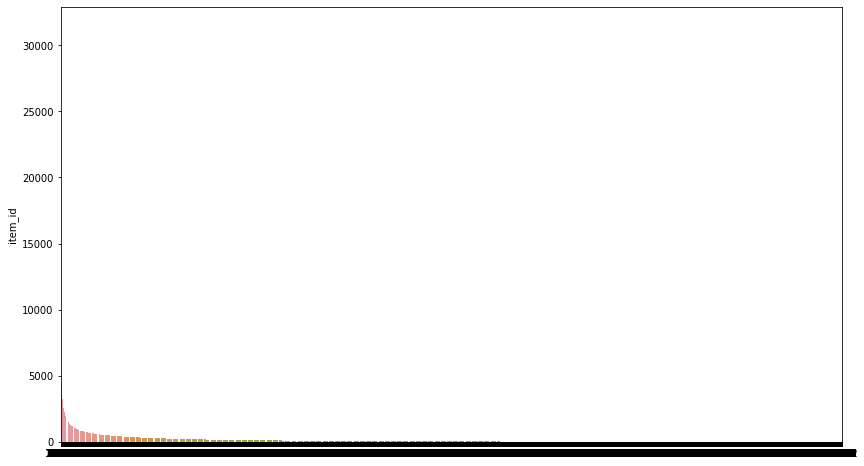

In [335]:
# number of transactions per item in the sales dataframe
item_id_count = sales['item_id'].value_counts(ascending=False)
plt.figure(figsize=(14,8))
sns.barplot(x=item_id_count.index , y=item_id_count , order=item_id_count.index)
plt.show()

in the sales dataframe, the number of transactions per item is not uniformly distributed, we have some items that have more than 9000 transactions and other with just one

In [487]:
del item_id_count
gc.collect()

860

In [336]:
sales['item_id'].value_counts(ascending=False).head()

20949    31340
5822      9408
17717     9067
2808      7479
4181      6853
Name: item_id, dtype: int64

In [337]:
sales['item_id'].value_counts(ascending=False).tail()

729      1
10973    1
21202    1
2775     1
0        1
Name: item_id, dtype: int64

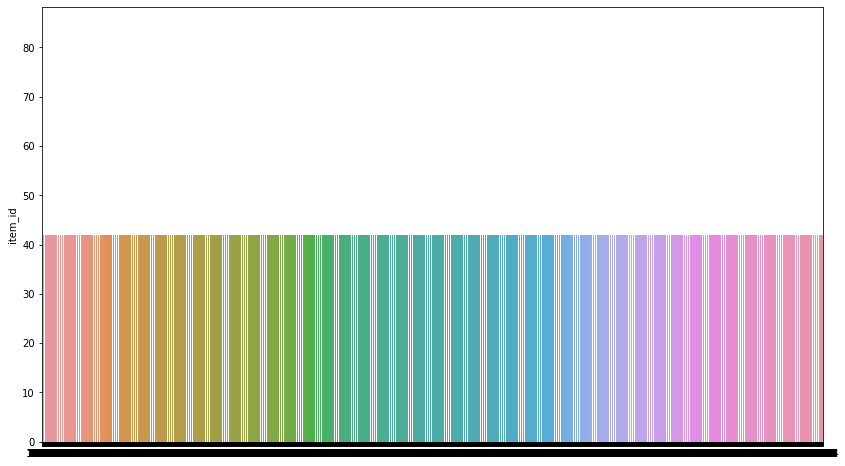

In [338]:
# number of transactions per item in the test dataframe
item_id_count_test = test['item_id'].value_counts(ascending=False)
plt.figure(figsize=(14,8))
sns.barplot(x=item_id_count_test.index , y=item_id_count_test , order=item_id_count_test.index)
plt.show()

in the test dataframe, the number of appearance per item is perfectly uniform.
in order the keep the information from sales dataframe we will have to mean encode item_id 

## Test set

In [37]:
# checking test shape
print(f'test dataframe shape: {test.shape}')

# looking for missing values
print(test.isna().sum())

test.head()

test dataframe shape: (214200, 3)
ID         0
shop_id    0
item_id    0
dtype: int64


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [38]:
# first we need to check that the all the shops and items that are in the test set are also included in the sales set,
# otherwise it will be inaccurate to do predictions on shops and products that we don't have historical data

shop_id_intersection = list(set(sales['shop_id']).intersection(set(test['shop_id'])))
item_id_intersection  = list(set(sales['item_id']).intersection(set(test['item_id'])))
# checking that all shop_id in test exist in sales
print('intersection between sales and test for shop_id: ',len(shop_id_intersection))
print('number of shop_id in test: ',test['shop_id'].nunique())

# checking that the item_id in test exist in sales
print('intersection between sales and test for item ',len(item_id_intersection))
print('number of item_id in test: ',test['item_id'].nunique())

intersection between sales and test for shop_id:  42
number of shop_id in test:  42
intersection between sales and test for item  4737
number of item_id in test:  5099


all the shops in test data are included in sales but some items in test data that are not in sales dataframe.

In [39]:
# let's store the id of the items that are in test set and not in sales
item_id_diff = np.setdiff1d(list(test['item_id']),item_id_intersection)

we will look for the closest item_id in sales using levenshtein distance to replace those in item_id_diff (we assume here that quite similar products name have quite the same behaviour in term of sales)

In [40]:
# installing jellyfish package to compute levenshtein distance
!pip install jellyfish

In [41]:
#test
sales_item_id = sales['item_id'].unique()
item_min_distance = []
for item_id_1 in tqdm_notebook(item_id_diff):
  table = []
  index = items[items['item_id']==item_id_1].index[0]
  # comparing item_id_1 name to 20 ones before and 20 ones after
  for item_id_2 in items.loc[index-20:index+20,'item_id']:
    if item_id_2 != item_id_1:
      if item_id_2 in sales_item_id:
        dist = jellyfish.levenshtein_distance(items[items['item_id']==item_id_1]['item_name'].values[0], items[items['item_id']==item_id_2]['item_name'].values[0])
        table.append([item_id_1, item_id_2, dist])
      else:
        pass
    else:
      pass
  table = pd.DataFrame(np.vstack(table), columns = ['item_id_1','item_id_2','distance'])
  item_min_distance.append(table.loc[table.distance==table.distance.min(),:].values[0].tolist())
item_min_distance = pd.DataFrame(item_min_distance, columns = ['item_id_1','item_id_2','distance'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [42]:
item_min_distance.head()

,item_id_1,item_id_2,distance
0,83,82,11
1,140,141,21
2,168,169,2
3,173,153,43
4,204,208,16


In [43]:
# we can now replace the item_id in test that are not in sales with the closest ones we found previously
# first let's create a dictionnary with keys equal to item_1 and values equal to item_2
items_dict = pd.Series(item_min_distance['item_id_2'].values,item_min_distance['item_id_1'].values).to_dict()

In [44]:
# now we can replace the item_id in test set
test['item_id'] = test['item_id'].replace(items_dict)

In [45]:
del items_dict
gc.collect()

14006

In [46]:
# checking that everything has been done correctly
item_id_intersection  = list(set(sales['item_id']).intersection(set(test['item_id'])))

# checking that the item_id in test exist in sales
print('intersection between sales and test for item ',len(item_id_intersection))
print('number of item_id in test: ',test['item_id'].nunique())

intersection between sales and test for item  4935
number of item_id in test:  4935


good ! all item_id in test set are included in sales set

In [47]:
# for the test set we need to create a column date_block_num with value equal to 34
# (objective is to predict sales for the 34th month)
test['date_block_num']=34

we also need to store the test set ID column and then drop it because we don't have a similar column in sales and we will need it to build our submission dataframe

In [48]:
# storing the IDs
test_ID = test['ID']

In [49]:
# dropping the ID column
test.drop('ID',axis=1,inplace=True)

# Get a feature matrix

Since the competition task is to make a monthly prediction, we need to aggregate the data to montly level before doing any encodings. The following code-cell serves just that purpose

In [50]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols, as_index = False).agg(target=pd.NamedAgg(column='item_cnt_day',aggfunc='sum'))
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'], as_index = False).agg(target_shop=pd.NamedAgg(column='item_cnt_day',aggfunc='sum'))
# Join it to the grid
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'], as_index = False).agg(target_item=pd.NamedAgg(column='item_cnt_day',aggfunc='sum'))
# Join it to the grid
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Category for each item for sales and test datasets
item_category_mapping = items[['item_id','item_category_id']]
# Join it to the grid for all_data
all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
# Join it to the grid for test
test = pd.merge(test, item_category_mapping, how='left', on='item_id')

# use the downcast function to save memory
all_data = downcast_dtypes(all_data)

del sales, grid, gb 
gc.collect();

In [51]:
print('all_data shape: ', all_data.shape)
all_data.head()

all_data shape:  (10895954, 7)


,shop_id,item_id,date_block_num,target,target_shop,target_item,item_category_id
0,59,22154,0,1.0,2017.0,18.0,37
1,59,2552,0,0.0,2017.0,0.0,58
2,59,2554,0,0.0,2017.0,1.0,58
3,59,2555,0,0.0,2017.0,2.0,56
4,59,2564,0,0.0,2017.0,5.0,59


In [52]:
# now we can concatenate all_data with test set
all_data = pd.concat([all_data,test])

In [53]:
# checking missing values
all_data[all_data['date_block_num']==34].isna().sum()

shop_id                  0
item_id                  0
date_block_num           0
target              214200
target_shop         214200
target_item         214200
item_category_id         0
dtype: int64

In [54]:
# filling the missing values with 0
all_data.fillna(0,inplace=True)

# Feature engineering

first, let's create a new feature by concatenating shop_id and item_id. this feature should be valuable because it gives information about selling performances for an item in a specific shop

In [55]:
all_data['shop_id-item_id'] = all_data['shop_id'].astype(str)+'-'+all_data['item_id'].astype(str)

## Mean encoding

now we are going to mean encode the categorical features shop_id, item_id, item_category and shop_id-item_id using KFold 

In [56]:
# categorical features to encode
categorical_feat = ['shop_id','item_id','item_category_id','shop_id-item_id']

# target columns for encoding the categorical features
target_cols = ['target']

### KFold scheme

In [57]:
# first we encode without regularization according to target, target_shop and target_item
for targ in target_cols:
    # encoding shop_id and item_id categorical features
    for cat_feat in categorical_feat:
        # Calculate a mapping: {item_id: target_mean}
        mean = all_data.groupby(cat_feat)[targ].mean()

        # In our non-regularized case we just *map* the computed means to the `item_id`'s
        all_data[cat_feat+'_'+targ+'_enc'] = all_data[cat_feat].map(mean)

        # Fill NaNs
        all_data[cat_feat+'_'+targ+'_enc'].fillna(all_data[targ].mean(), inplace=True)
        
        all_data[cat_feat+'_'+targ+'_enc'].fillna(all_data[targ].mean(),inplace = True)

In [58]:
# then we encode using KFold scheme
from sklearn.model_selection import KFold

# mean encoding categorical features according to target, target_shop and target_item
for targ in target_cols:
    # encoding shop_id and item_id categorical features
    for cat_feat in categorical_feat:
        y_train = all_data[targ].values # target variable
        skf = KFold(5,shuffle = False)

        for tr_ind , val_ind in skf.split(all_data):
            x_tr , x_val = all_data.iloc[tr_ind] , all_data.iloc[val_ind]

            means = x_val[cat_feat].map(x_tr.groupby(cat_feat)[targ].mean())
            x_val[cat_feat+'_'+targ+'_enc'] = means
            all_data.iloc[val_ind] = x_val
            
            del x_tr , x_val , means
            gc.collect();

        all_data[cat_feat+'_'+targ+'_enc'].fillna(all_data[targ].mean(),inplace = True)
        
        encoded_feature = all_data[cat_feat+'_'+targ+'_enc'].values
        corr = np.corrcoef(all_data[targ].values, encoded_feature)[0][1]
        print(f'correlation between {cat_feat+"_"+targ+"_enc"} and {targ}: ', corr)
        
del y_train , encoded_feature, corr 
gc.collect();

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


correlation between shop_id_target_enc and target:  0.07074898945441549
correlation between item_id_target_enc and target:  0.41651160872155435
correlation between item_category_id_target_enc and target:  0.34493797694580214
correlation between shop_id-item_id_target_enc and target:  0.5930963664392332


### expanding mean scheme

In [62]:
# encoding according to target, target_shop and target_item
for targ in target_cols:
    for cat_feat in categorical_feat:
        cumsum = all_data.groupby(cat_feat)[targ].cumsum()-all_data[targ]
        cumcnt = all_data.groupby(cat_feat)[targ].cumcount()

        all_data[cat_feat+'_'+targ+'_exp_mean_enc'] = cumsum/cumcnt
        all_data[cat_feat+'_'+targ+'_exp_mean_enc'].fillna(all_data[targ].mean(), inplace=True)
        
        encoded_feature = all_data[cat_feat+'_'+targ+'_exp_mean_enc'].values
        corr = np.corrcoef(all_data[targ].values, encoded_feature)[0][1]
        print(f'correlation between {cat_feat+"_"+targ+"_exp_mean_enc"} and {targ}: ',corr)
        
del cumsum , cumcnt , encoded_feature, corr 
gc.collect();

correlation between shop_id_target_exp_mean_enc and target:  0.07385655814653491
correlation between item_id_target_exp_mean_enc and target:  0.5097514852004934
correlation between item_category_id_target_exp_mean_enc and target:  0.39172173174548036
correlation between shop_id-item_id_target_exp_mean_enc and target:  0.586423559996283


## Feature engineering

After creating a grid, we can calculate some features. We will use lags from [1, 2, 3, 4, 5, 12] months ago.

In [63]:
index_cols_2 = ['shop_id', 'item_id', 'item_category_id' , 'date_block_num']
# we are going to create lags on the following columns : target, target_item, target_shop (target_cols list)
# let's set different months shift ranges we want to introduce 
shift_range = [1, 2, 3, 4, 5, 12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols_2 + target_cols].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in target_cols else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols_2, how='left').fillna(0)

del train_shift
   

# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12] 

# List of all lagged features
#fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
# We will drop these at fitting stage
#to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

gc.collect();

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


One Hot Encoding categorical features with low cardinality
- shop_city
- shop category


In [64]:
shops_OH = pd.get_dummies(shops,columns = ['shop_city','shop_category'],drop_first=True)

In [65]:
# merging the one hot encoded features with all_data
all_data = pd.merge(all_data,shops_OH, how='left' , on='shop_id').drop('shop_name',axis=1)

## feature extraction

now that we have created lagged features from target, target_shop and target_item we can vectorize text from item name, category name and shop name that can be very valuable for our purpose

In [66]:
# Installing nltk package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install nltk

In [67]:
# installing pymystem3 v3.0 (had some troubles with latest version, please take a look at https://github.com/nlpub/pymystem3/issues/28)
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
!cp mystem /bin

--2021-08-02 18:02:18--  http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving download.cdn.yandex.net (download.cdn.yandex.net)... 5.45.205.241, 5.45.205.242, 5.45.205.244, ...
Connecting to download.cdn.yandex.net (download.cdn.yandex.net)|5.45.205.241|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://cache-mskm910.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz [following]
--2021-08-02 18:02:19--  http://cache-mskm910.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving cache-mskm910.cdn.yandex.net (cache-mskm910.cdn.yandex.net)... 5.45.220.20, 2a02:6b8:0:2002::1b
Connecting to cache-mskm910.cdn.yandex.net (cache-mskm910.cdn.yandex.net)|5.45.220.20|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16457938 (16M) [application/octet-stream]
Saving to: ‘mystem-3.0-linux3.1-64bit.tar.gz.1’

mystem-3.0-linux3.1 100%[===================>] 

In [68]:
import nltk
from pymystem3 import Mystem
from nltk.corpus import stopwords 
nltk.download('stopwords')


mystem = Mystem() 
russian_stopwords = stopwords.words("russian")
from string import punctuation

#Preprocess function
def my_tokenizer(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    
    return tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [69]:
vectorizer = TfidfVectorizer(max_features = 10 , tokenizer=my_tokenizer)

In [70]:
#####tokenizing item_name#####
X = vectorizer.fit_transform(items['item_name'])
# transforming X to a DataFrame
X_df = pd.DataFrame(X.toarray())
X_df['item_id']=items['item_id']
# now we can merge X_df and all_data on item_id
all_data = pd.merge(all_data,X_df,on='item_id',how='left')
all_data = downcast_dtypes(all_data)

del X,X_df
gc.collect();

In [71]:
all_data = downcast_dtypes(all_data)
print('data shape: ',all_data.shape)
all_data.head()

data shape:  (6623998, 63)


,shop_id,item_id,date_block_num,target,target_shop,target_item,item_category_id,shop_id-item_id,shop_id_target_enc,item_id_target_enc,item_category_id_target_enc,shop_id-item_id_target_enc,shop_id_target_exp_mean_enc,item_id_target_exp_mean_enc,item_category_id_target_exp_mean_enc,shop_id-item_id_target_exp_mean_enc,target_lag_1,target_lag_2,target_lag_3,target_lag_4,target_lag_5,target_lag_12,shop_city_адыгея,shop_city_балашиха,shop_city_волжский,...,shop_city_ростовнадону,shop_city_самара,shop_city_сергиев,shop_city_спб,shop_city_сургут,shop_city_томск,shop_city_тюмень,shop_city_уфа,shop_city_химки,shop_city_чехов,shop_city_якутск,shop_city_ярославль,shop_category_интернет-магазин,shop_category_тц,shop_category_цифровой,0,1,2,3,4,5,6,7,8,9
0,54,10297,12,4.0,8198.0,23.0,37,54-10297,0.923818,0.101485,0.179418,0.363636,0.978964,0.483516,0.198286,1.500000,3.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,1.000000,0.0,0.0
1,54,10296,12,3.0,8198.0,17.0,38,54-10296,0.923818,0.121069,0.185102,0.400000,0.978995,0.521739,0.210049,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0.000000,0.62163,0.558631,0.0,0.0,0.0,0.0,0.549096,0.0,0.0
2,54,10298,12,14.0,8198.0,182.0,40,54-10298,0.923818,3.074610,0.255681,14.416667,0.979016,13.299270,0.264266,49.000000,21.0,119.0,7.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0.582887,0.60437,0.543120,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,54,10300,12,3.0,8198.0,26.0,37,54-10300,0.923818,0.675947,0.179418,3.333333,0.979148,3.416058,0.198295,10.666667,1.0,31.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,1.000000,0.0,0.0
4,54,10284,12,1.0,8198.0,3.0,57,54-10284,0.923818,0.092166,0.103896,0.333333,0.979168,0.133772,0.121053,0.300000,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,1.000000,0.0,0.0


first we need  to set our train, validation and test sets
for train set we take all the recordings corresponding to months 0 to 32
for validation set we take all the recordings from month 33
and for test set we take all the recordings from month 34

In [73]:
# train set
X_train = all_data[all_data['date_block_num']<33].drop(['target','target_shop','target_item','shop_id-item_id'],axis=1)
y_train = all_data[all_data['date_block_num']<33]['target']
print('X_train shape: ',X_train.shape)
print('y_train shape: ',y_train.shape)

X_train shape:  (6171626, 59)
y_train shape:  (6171626,)


In [74]:
# validation set
X_val = all_data[all_data['date_block_num']==33].drop(['target','target_shop','target_item','shop_id-item_id'],axis=1)
y_val = all_data[all_data['date_block_num']==33]['target']
print('X_val shape: ',X_val.shape)
print('y_val shape: ',y_val.shape)

X_val shape:  (238172, 59)
y_val shape:  (238172,)


In [75]:
# test set
X_test = all_data[all_data['date_block_num']==34].drop(['target','target_shop','target_item','shop_id-item_id'],axis=1)
print('X_test shape: ',X_test.shape)

X_test shape:  (214200, 59)


In [76]:
del all_data
gc.collect()

648

# Ensembling

In [84]:
from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster , features):
    fig , ax = plt.subplots(1,1,figsize = (12,8))
    return plot_importance(booster = booster , ax = ax)

import time

In [79]:
#implementing xgboost ~

ts = time.time()

model = XGBRegressor(
    max_depth=9,
    n_estimators=500,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    random_state=42,
    n_jobs=-1)

model.fit(
    X_train.values, 
    y_train.values, 
    eval_metric="rmse", 
    eval_set=[(X_train.values, y_train.values), (X_val.values, y_val.values)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[18:05:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:05:48] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:3.43438	validation_1-rmse:2.60006
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:3.34601	validation_1-rmse:2.522
[2]	validation_0-rmse:3.26516	validation_1-rmse:2.43861
[3]	validation_0-rmse:3.19472	validation_1-rmse:2.37218
[4]	validation_0-rmse:3.13051	validation_1-rmse:2.31108
[5]	validation_0-rmse:3.08332	validation_1-rmse:2.26557
[6]	validation_0-rmse:3.03633	validation_1-rmse:2.22181
[7]	validation_0-rmse:3.00027	validation_1-rmse:2.20062
[8]	validation_0-rmse:2.96914	validation_1-rmse:2.1842

2210.1449072360992

In [80]:
# submission file~

XGB_pred = model.predict(X_test.values).clip(0, 20)

submission = pd.DataFrame({
    "ID": test_ID, 
    "item_cnt_month": XGB_pred
})
submission.to_csv('submission_v1.3', index=False)